In [1]:
import json
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
phase = 'train_epochs'
if 'Epochs' in phase:
    phase = 'train_epochs'
    print('epochs')

### In the wild dataset

In [122]:
def find_unique_authors_create_dataFrame(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    unique_authors = set()
    authors_list = []
    ids_list = []
    quotes_list = []
    labels_list = []
    author_id_map = {}
    current_id = 0
    for item in data:
        author = item.get('speaker')
        if author:
            if author not in author_id_map:
                    author_id_map[author] = current_id
                    current_id += 1
            unique_authors.add(author)
            authors_list.append(author)
            ids_list.append(author_id_map[author])
            quotes_list.append(item.get('content'))
            labels_list.append(item.get('label'))
    data = pd.DataFrame({
        'label': ids_list,
        'author_name': authors_list,
        'text': quotes_list,
        'type': labels_list,
        'length': [len(quote) for quote in quotes_list]
    })
    data['author_name'] = data['author_name'].replace('JFK', 'John F. Kennedy').replace('FDR', 'Franklin D. Roosevelt').replace('Harry Truman', 'Harry S. Truman').replace('Mr. Rogers','Fred Rogers')
    author_id_map['John F. Kennedy'] = author_id_map.pop('JFK')
    author_id_map['Franklin D. Roosevelt'] = author_id_map.pop('FDR')
    author_id_map['Harry S. Truman'] = author_id_map.pop('Harry Truman')
    author_id_map['Fred Rogers'] = author_id_map.pop('Mr. Rogers')
    return unique_authors, data, author_id_map

In [60]:
def plot_author_quotes_count(data):
    quote_counts = data['author_name'].value_counts()
    plt.figure(figsize=(10, 8))
    quote_counts.plot(kind='bar', color=plt.cm.viridis(np.linspace(0, 1, len(quote_counts))))
    plt.title('Number of Quotes per Author')
    plt.xlabel('Author')
    plt.ylabel('Number of Quotes')
    plt.xticks(rotation=90)
    plt.show()
    return quote_counts

In [124]:
json_file_path = '../Data/InTheWild/wild_transcription_meta.json'
unique_authors, data, author_id_map = find_unique_authors_create_dataFrame(json_file_path)

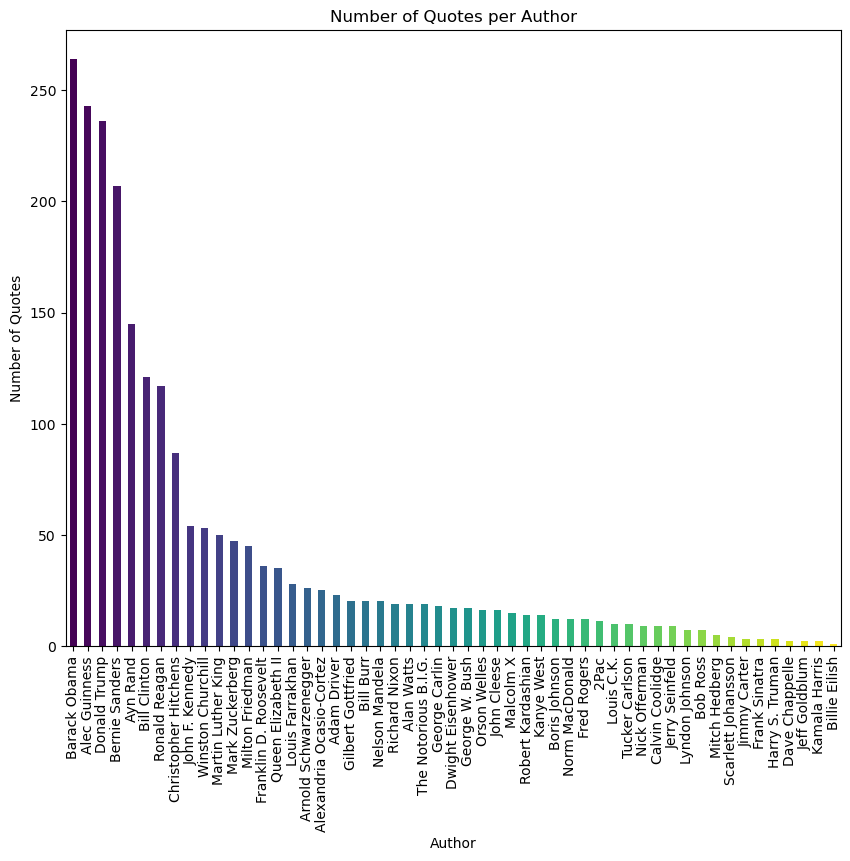

In [125]:
quotes_count = plot_author_quotes_count(data[data['length'] > 20])

### Wikiquotes

In [126]:
import os
folder_path = '../Data/WikiQuotes'
metadata_file = os.path.join(folder_path, 'quotes-500-en-sources.csv')
metadata_df = pd.read_csv(metadata_file)
quotes_file = os.path.join(folder_path, 'quotes-500-en-quotes.csv')
quotes_df = pd.read_csv(quotes_file)
filtered_quotes_df = quotes_df[quotes_df['source_id'].isin(metadata_df[metadata_df['name'].isin(author_id_map.keys())]['source_id'])]
source_id_to_name = dict(zip(metadata_df['source_id'], metadata_df['name']))
filtered_quotes_df['author_name'] = filtered_quotes_df['source_id'].map(source_id_to_name)
new_data = pd.DataFrame({
    'label': filtered_quotes_df['author_name'].map(author_id_map),
    'author_name': filtered_quotes_df['author_name'],
    'text': filtered_quotes_df['quote'],
    'type': 'bona-fide',
    'length': filtered_quotes_df['quote'].apply(len)
})

data = pd.concat([data, new_data], ignore_index=True)


/tmp/ipykernel_184401/2683164703.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_quotes_df['author_name'] = filtered_quotes_df['source_id'].map(source_id_to_name)


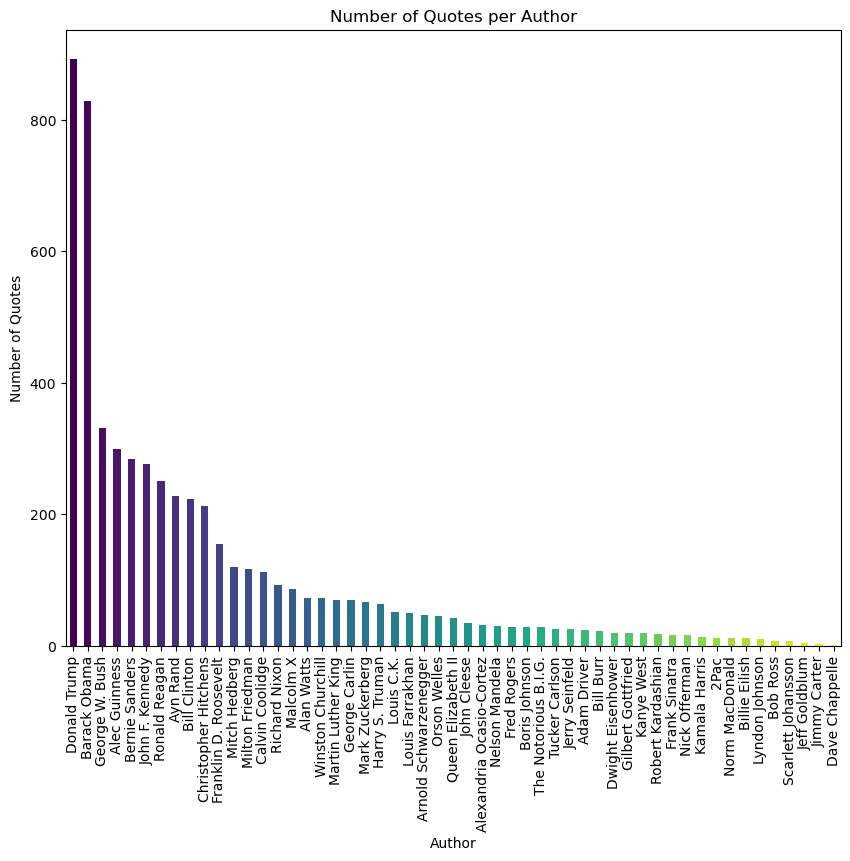

In [127]:
quotes_count_wiki = plot_author_quotes_count(data)

In [128]:
min_length = data['length'].min()
max_length = data['length'].max()
average_length = data['length'].mean()

print(f"Minimum length of quotes: {min_length}")
print(f"Maximum length of quotes: {max_length}")
print(f"Average length of quotes: {average_length:.2f}")

Minimum length of quotes: 2
Maximum length of quotes: 588
Average length of quotes: 151.20


### Data from hugging face used in:
Paper: Goel, S., Madhok, R., & Garg, S. (2018). Proposing Contextually Relevant Quotes for Images. Advances in Information Retrieval. Springer. doi: 10.1007/978-3-319-76941-7_49


Repo card metadata block was not found. Setting CardData to empty.


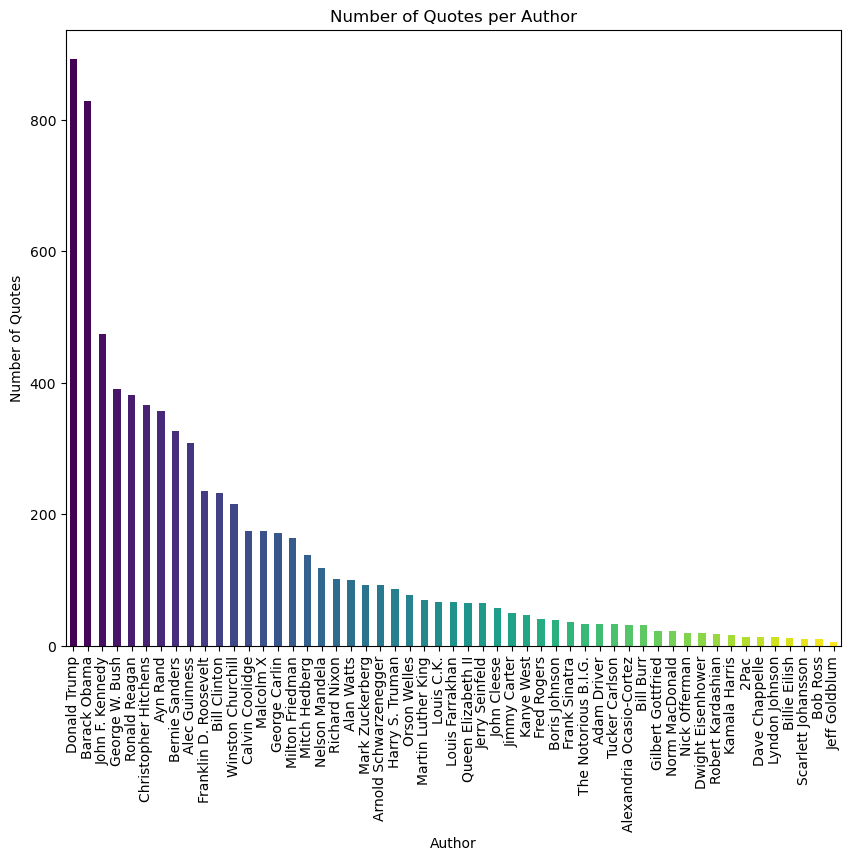

author_name
Donald Trump                892
Barack Obama                828
John F. Kennedy             474
George W. Bush              391
Ronald Reagan               381
Christopher Hitchens        366
Ayn Rand                    357
Bernie Sanders              326
Alec Guinness               308
Franklin D. Roosevelt       235
Bill Clinton                233
Winston Churchill           215
Calvin Coolidge             174
Malcolm X                   174
George Carlin               171
Milton Friedman             164
Mitch Hedberg               138
Nelson Mandela              119
Richard Nixon               102
Alan Watts                  100
Mark Zuckerberg              93
Arnold Schwarzenegger        92
Harry S. Truman              87
Orson Welles                 78
Martin Luther King           70
Louis C.K.                   67
Louis Farrakhan              66
Queen Elizabeth II           65
Jerry Seinfeld               65
John Cleese                  57
Jimmy Carter                

In [129]:
from datasets import load_dataset
ds = load_dataset("jstet/quotes-500k")
df_train = ds['train'].to_pandas()
df_train.rename(columns={'author': 'author_name'}, inplace=True)
def add_quotes_to_data(data, quotes_df, author_id_map):
    filtered_quotes_df = quotes_df[quotes_df['author_name'].isin(author_id_map.keys())]
    filtered_quotes_df = filtered_quotes_df[(filtered_quotes_df['author_name'] != 'Barack Obama') & (filtered_quotes_df['author_name'] != 'Donald Trump')]
    new_data = pd.DataFrame({
        'label': filtered_quotes_df['author_name'].map(author_id_map),
        'author_name': filtered_quotes_df['author_name'],
        'text': filtered_quotes_df['quote'],
        'type': 'bona-fide',
        'length': filtered_quotes_df['quote'].apply(len)
    })
    data = pd.concat([data, new_data], ignore_index=True)
    return data

data = add_quotes_to_data(data, df_train, author_id_map)
quotes_count_wiki = plot_author_quotes_count(data)
quotes_count_wiki

Number of authors that have more then 100 quotes: 9


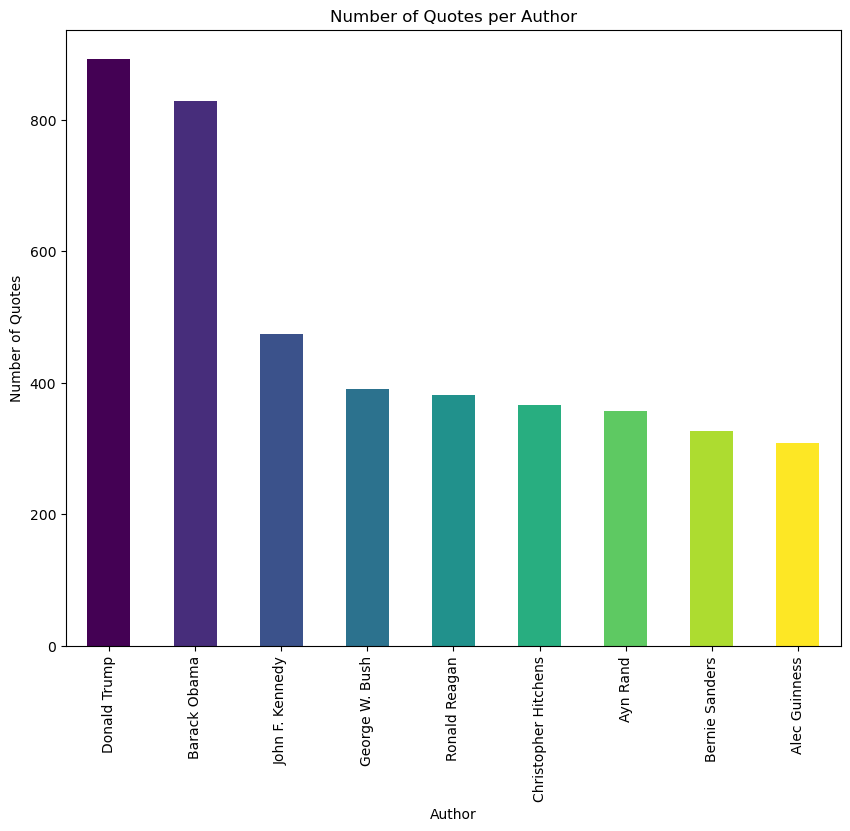

author_name
Donald Trump            892
Barack Obama            828
John F. Kennedy         474
George W. Bush          391
Ronald Reagan           381
Christopher Hitchens    366
Ayn Rand                357
Bernie Sanders          326
Alec Guinness           308
Name: count, dtype: int64

In [130]:
label_counts = data['label'].value_counts()
labels_to_keep = label_counts[label_counts >= 250].index
data_more_250 = data[data['label'].isin(labels_to_keep)]
print(f"Number of authors that have more then 100 quotes: {len(data_more_250['label'].unique())}")
plot_author_quotes_count(data_more_250)

In [131]:
data.to_csv('../Data/WikiQuotes_final.csv', index=False)

In [16]:
import pandas as pd
df = pd.read_csv('../../Data/WikiQuotes.csv')


In [17]:
unique_pairs = df[['label', 'author_name']].drop_duplicates()
unique_pairs


,label,author_name
0,0,Donald Trump
1,1,Franklin D. Roosevelt
3,2,Barack Obama
4,3,Bernie Sanders
8,4,Ayn Rand
14,5,Alec Guinness
16,6,Bill Clinton
19,7,George W. Bush
32,8,Ronald Reagan
34,9,John F. Kennedy


In [31]:
texts_by_author = df.groupby('label')['text'].apply(list).to_dict()
import random 
random.choice(texts_by_author[0])
# labels = list(texts_by_author.keys())

"So I said to myself, you know, nobody's ever going to know unless I run, because I'm really proud of my success."

In [12]:
df['length'].describe()

count    4621.000000
mean      157.329582
std       122.682359
min        21.000000
25%        59.000000
50%       116.000000
75%       231.000000
max       599.000000
Name: length, dtype: float64

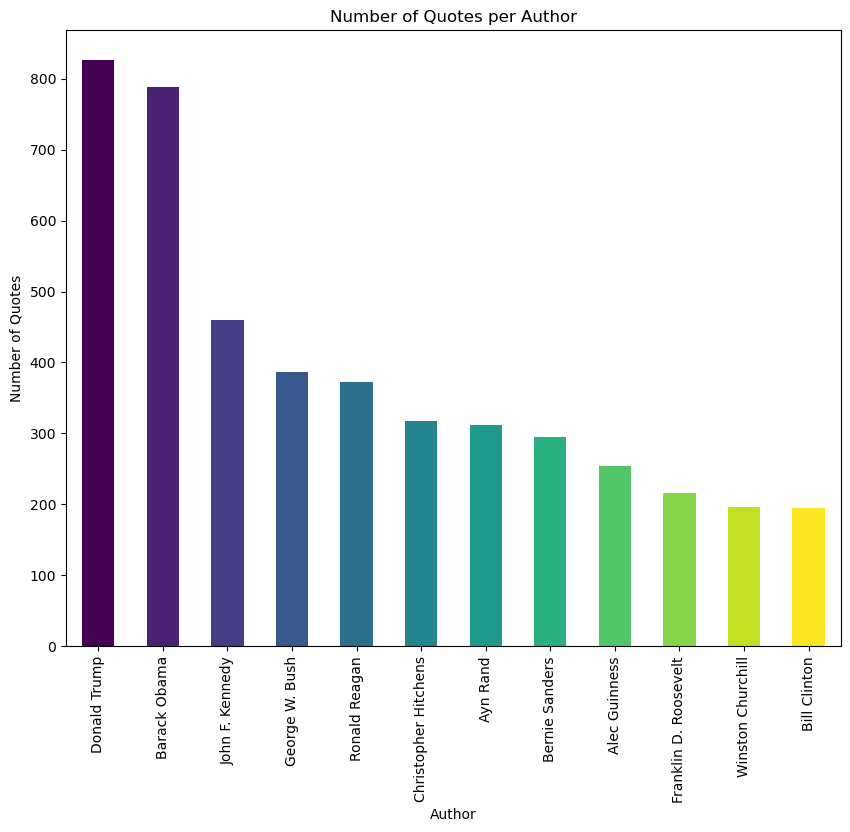

author_name
Donald Trump             827
Barack Obama             788
John F. Kennedy          460
George W. Bush           387
Ronald Reagan            373
Christopher Hitchens     318
Ayn Rand                 312
Bernie Sanders           295
Alec Guinness            254
Franklin D. Roosevelt    216
Winston Churchill        196
Bill Clinton             195
Name: count, dtype: int64

In [22]:
plot_author_quotes_count(df)

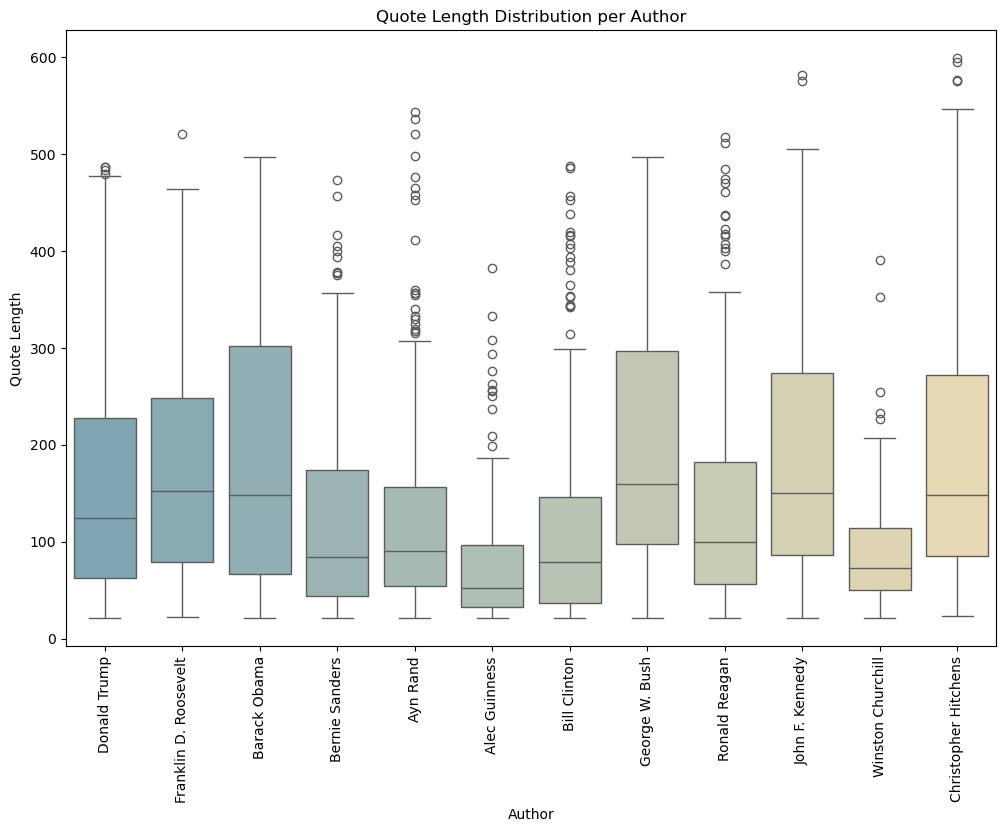

<Figure size 640x480 with 0 Axes>

In [21]:
import seaborn as sns
def plot_quotes_stats(data):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='author_name', y='length', data=data, palette='blend:#7AB,#EDA', hue='author_name')
    plt.title('Quote Length Distribution per Author')
    plt.xlabel('Author')
    plt.ylabel('Quote Length')
    plt.xticks(rotation=90)
    plt.show()
    # plt.savefig('quote_length_distribution.png')
    
plot_quotes_stats(df)

In [108]:
def load_data(data ):
    """
    Loads and processes the dataset.
    Args:
        args (argparse.Namespace): The arguments containing the following attributes:
            - data (str): Path to the CSV file containing the dataset.
            - min_quotes_per_author (int): Minimum number of quotes required per author.
    Returns:
        tuple: A tuple containing:
            - data (pd.DataFrame): The processed dataset excluding spoofed data.
            - spoofed_data (pd.DataFrame): The dataset containing only spoofed data.
            - author_id_map (dict): A dictionary mapping new author labels to author names. E.g. {0: 'Donald Trump', 1: 'Barack Obama', 2: 'John F. Kennedy', ...}
    """
    
    data = pd.read_csv(data)
    data = data.dropna()
    number_quotes = 450
    data['label'] = data['label'].astype('int')
    label_counts = data['label'].value_counts()
    # Keep only authors with more than number_quotes quotes
    labels_to_keep = label_counts[label_counts >= number_quotes].index
    data = data[data['label'].isin(labels_to_keep)]
    num_authors = len(data['label'].unique())
    print(f"Number of authors that have more then {number_quotes} quotes: {num_authors}")
    
    # Map author labels to new labels starting from 0
    author_id_map = data[['label', 'author_name']].drop_duplicates().set_index('label').to_dict()['author_name']
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(labels_to_keep)}
    data['label'] = data['label'].map(label_mapping)
    author_id_map = {new_label: author_id_map[old_label] for old_label, new_label in label_mapping.items()}
    
    # Split spoofed data
    spoofed_data = data[data['type'] == 'spoof']
    data = data[data['type'] != 'spoof'] 
    return data, spoofed_data, author_id_map

In [104]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import pandas as pd
import config
from model import AuthorshipLLM
from dataset import AuthorTripletLossDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [109]:

device = config.get_device()
data = '/home/infres/iivanova-23/DADA/Data/WikiQuotes.csv'
repo = '/home/infres/iivanova-23/DADA/output/n_authors_3/FacebookAI/roberta-large_32_20/'
model = AuthorshipLLM('roberta-large')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
model.to(device)
config.load_checkpoint(model, optimizer, f'{repo}/final.pth')
data, spoofed_data, author_id_map = load_data(data)

train_data, temp_data = train_test_split(data, test_size=0.4, stratify=data['label'])
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['label'])
train_dataset = AuthorTripletLossDataset(train_data, 'roberta-large', train=True)
val_dataset = AuthorTripletLossDataset(val_data, 'roberta-large', train=True)
test_dataset = AuthorTripletLossDataset(test_data, 'roberta-large', train=True)
spoofed_test_dataset = AuthorTripletLossDataset(spoofed_data, 'roberta-large', train=False)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

num_workers = 0
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers)
spoofed_data_loader = DataLoader(spoofed_test_dataset, batch_size=32, shuffle=False, num_workers=num_workers)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/infres/iivanova-23/DADA/authorship_attribution/config.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializ

Loading model from /home/infres/iivanova-23/DADA/output/n_authors_3/FacebookAI/roberta-large_32_20//final.pth
Model loaded from /home/infres/iivanova-23/DADA/output/n_authors_3/FacebookAI/roberta-large_32_20//final.pth
Number of authors that have more then 450 quotes: 3
Number of training samples: 1204
Number of validation samples: 402
Number of testing samples: 402


In [ ]:
def plot_cosine_distence_distribution(model, test_dataloader, device):
    """
    Plots the distribution of cosine distances between anchor/positive examples and anchor/negative examples.
    This function takes a dataloader containing batches of data, extracts embeddings
    using the model, and then calculates the cosine distance between anchor and positive examples and anchor and negatives.
    The resulting distribution of cosine distances is displayed as a histogram.
    Args:
        test_dataloader (DataLoader): A PyTorch DataLoader containing batches of test data. Each batch
                                       should be a dictionary with keys 'anchor_input_ids', 'anchor_attention_mask',
                                       'positive_input_ids', 'positive_attention_mask', and 'label'.
    Returns:
        None
    Note:
        - The function assumes that the model and device are already set up as attributes of the class.
    """
    
    model.eval()
    all_cosine_distances_positive = []
    all_cosine_distances_negative = []
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_dataloader:
            anchor_input_ids = batch['anchor_input_ids'].to(device)
            anchor_attention_mask = batch['anchor_attention_mask'].to(device)
            positive_input_ids = batch['positive_input_ids'].to(device)
            positive_attention_mask = batch['positive_attention_mask'].to(device)
            # negative_input_ids = batch['negative_input_ids'].to(device)
            # negative_attention_mask = batch['negative_attention_mask'].to(device)
            
            anchor_embeddings = model(anchor_input_ids, anchor_attention_mask)
            positive_embeddings = model(positive_input_ids, positive_attention_mask)
            dist_ax = torch.norm(anchor_embeddings - positive_embeddings, dim=1, p=2)
            
            cosine_similarity_pos = F.cosine_similarity(anchor_embeddings, positive_embeddings)
            cosine_distance_pos = 1 - cosine_similarity_pos
            all_cosine_distances_positive.extend(cosine_distance_pos.cpu().numpy())

            # negative_embeddings = model(negative_input_ids, negative_attention_mask)   
            # cosine_similarity_neg = F.cosine_similarity(anchor_embeddings, negative_embeddings)
            # cosine_distance_neg = 1 - cosine_similarity_neg
            # all_cosine_distances_negative.extend(cosine_distance_neg.cpu().numpy())
            anchor_labels = batch['label']
            negative_inputs_ids_list = batch['negative_input_ids']
            negative_attention_masks_list = batch['negative_attention_mask']
            negative_labels = batch['negative_labels']
            # print(negative_labels)
            for i in range(anchor_embeddings.size(0)): 
                min_dist = dist_ax[i] 
                # print(f"Pos dist: {min_dist}")
                pred_label = anchor_labels[i]
                # print(anchor_labels[i])
                negative_input_ids = negative_inputs_ids_list[i, 0].to(device)
                negative_attention_mask = negative_attention_masks_list[i, 0].to(device)
                negative_embeddings = model(negative_input_ids.unsqueeze(0), negative_attention_mask.unsqueeze(0))

                min_negative_embeddings = negative_embeddings
                for neg_idx in range(negative_inputs_ids_list.size(1)):  # N_negatives per anchor = #num_labels - 1
                    negative_input_ids = negative_inputs_ids_list[i, neg_idx].to(device)
                    negative_attention_mask = negative_attention_masks_list[i, neg_idx].to(device)
                    negative_embeddings = model(negative_input_ids.unsqueeze(0), negative_attention_mask.unsqueeze(0))
                    dist_bx = torch.norm(anchor_embeddings[i].unsqueeze(0) - negative_embeddings, dim=1, p=2)
                    if dist_bx < min_dist:
                        min_dist = dist_bx
                        pred_label = negative_labels[i][neg_idx]
                        min_negative_embeddings = negative_embeddings
                        # print(negative_labels[i][neg_idx])
                        print(f"+: {dist_ax[i]}, -: {dist_bx}, anchor: {anchor_labels[i]}, negative: {negative_labels[i][neg_idx]}")
                        # print(f"Min dist: {min_dist}, possible label: {correct_label}")
                cosine_similarity_neg = F.cosine_similarity(anchor_embeddings[i], min_negative_embeddings)
                cosine_distance_neg = 1 - cosine_similarity_neg
                all_cosine_distances_negative.extend(cosine_distance_neg.cpu().numpy())
                # print(f"Min cos neg: {cosine_distance_neg}, anchor {} ")
                if pred_label == anchor_labels[i]:
                    correct += 1
                total += 1

    accuracy = correct / total
    print(f"Accuracy: {accuracy}")
    
    data = pd.DataFrame({
        "Cosine Distance": np.concatenate([all_cosine_distances_positive, all_cosine_distances_negative]),
        "Pair Type": ["Anchor-Positive"] * len(all_cosine_distances_positive) + ["Anchor-Negative"] * len(all_cosine_distances_negative)
    })
    plt.figure(figsize=(6, 8))
    sns.violinplot(data=data, x="Pair Type", y="Cosine Distance", split=True, gap=.01, hue="Pair Type", inner="quartile")
    plt.ylabel("Cosine Distance")
    plt.title("Distribution of Cosine Distances Between Embeddings")
    plt.tight_layout()
    plt.savefig(f"{repo}/cosine_distances.png")
    plt.show()

    print(f"Cosine Distance (Anchor-Positive): {all_cosine_distances_positive}")
    print(f"Cosine Distance (Anchor-Negative): {all_cosine_distances_negative}")
    print(len(all_cosine_distances_positive), len(all_cosine_distances_negative))

tensor([[1, 2],
        [0, 1],
        [1, 2],
        [1, 2],
        [0, 2],
        [0, 2],
        [1, 2],
        [1, 2],
        [0, 1],
        [1, 2],
        [0, 2],
        [1, 2],
        [0, 2],
        [1, 2],
        [1, 2],
        [1, 2],
        [0, 2],
        [0, 1],
        [1, 2],
        [1, 2],
        [0, 1],
        [0, 2],
        [1, 2],
        [1, 2],
        [0, 2],
        [0, 2],
        [1, 2],
        [0, 2],
        [0, 2],
        [1, 2],
        [0, 2],
        [0, 2]])
+: 10.856218338012695, -: tensor([10.7404], device='cuda:0'), anchor: 1, negative: 2
+: 11.187492370605469, -: tensor([4.0435], device='cuda:0'), anchor: 1, negative: 0
tensor([[0, 1],
        [1, 2],
        [1, 2],
        [0, 1],
        [0, 2],
        [1, 2],
        [0, 2],
        [0, 2],
        [1, 2],
        [0, 2],
        [0, 2],
        [0, 1],
        [0, 2],
        [0, 2],
        [0, 2],
        [1, 2],
        [1, 2],
        [0, 1],
        [0, 1],
        [0, 2]

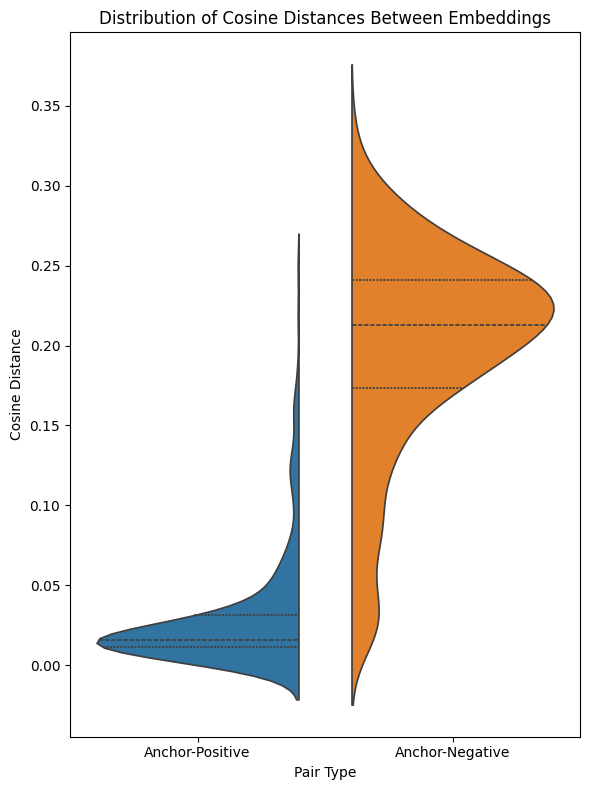

Cosine Distance (Anchor-Positive): [np.float32(0.019306004), np.float32(0.007919073), np.float32(0.025058985), np.float32(0.0119457245), np.float32(0.008719206), np.float32(0.0068280697), np.float32(0.018912971), np.float32(0.029670477), np.float32(0.022159457), np.float32(0.021804452), np.float32(0.14283025), np.float32(0.011146188), np.float32(0.0102600455), np.float32(0.010509789), np.float32(0.0135535), np.float32(0.016755998), np.float32(0.009759009), np.float32(0.038838983), np.float32(0.15747869), np.float32(0.010041952), np.float32(0.03231281), np.float32(0.015018821), np.float32(0.056987464), np.float32(0.035437346), np.float32(0.1525346), np.float32(0.04189992), np.float32(0.017656028), np.float32(0.010519266), np.float32(0.022649646), np.float32(0.011420548), np.float32(0.015984952), np.float32(0.013286471), np.float32(0.009340465), np.float32(0.07578802), np.float32(0.2183044), np.float32(0.028064847), np.float32(0.016270995), np.float32(0.036132216), np.float32(0.007392645

In [114]:
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers)
test_dataset = AuthorTripletLossDataset(test_data, 'roberta-large', train=False)
plot_cosine_distence_distribution(model,test_dataloader,device)

In [2]:
dict = {'a': 1, 'b': 2, 'c': 3}
dict['a']

1

In [12]:
data = pd.read_csv('../../Data/WikiQuotes_final.csv')
data_small = pd.read_csv('../../Data/WikiQuotes.csv')

In [6]:
import seaborn as sns

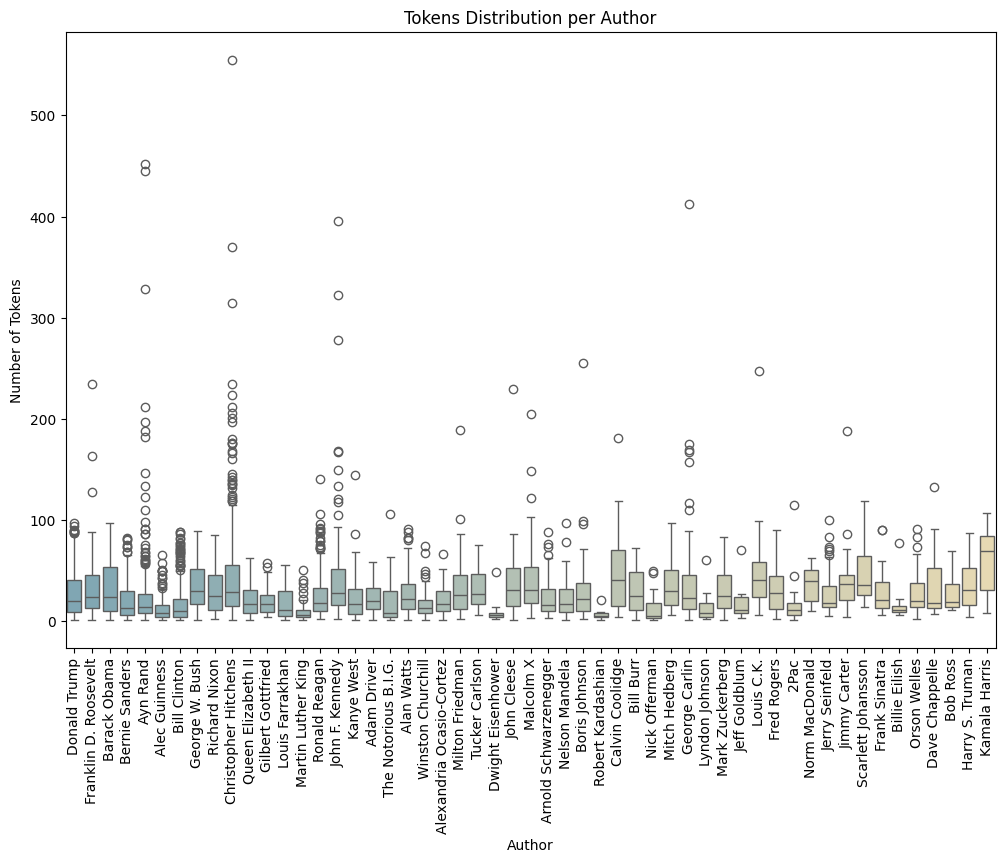

In [9]:
def tokens_count(data):
    data['tokens'] = data['text'].apply(lambda x: len(x.split()))
    return data

def plot_tokens_distribution(data):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='author_name', y='tokens', data=data, palette='blend:#7AB,#EDA', hue='author_name')
    plt.title('Tokens Distribution per Author')
    plt.xlabel('Author')
    plt.ylabel('Number of Tokens')
    plt.xticks(rotation=90)
    plt.show()

data = tokens_count(data)
plot_tokens_distribution(data)

In [11]:
data['tokens'].mean()

29.005762530152776

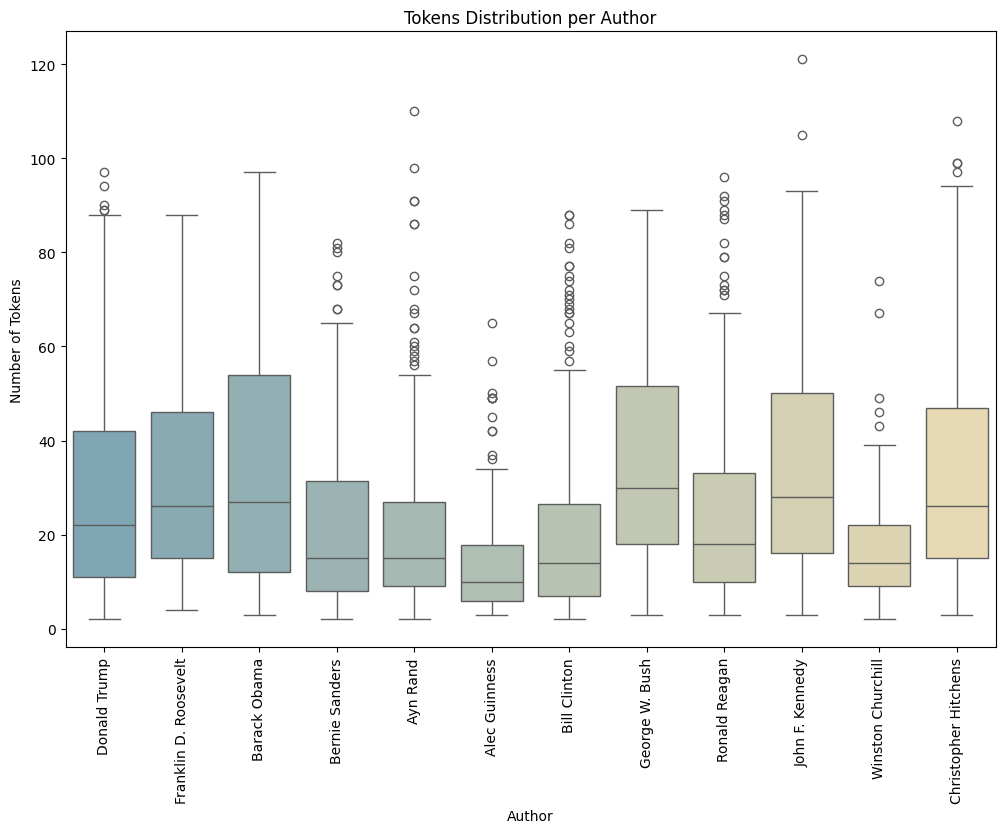

In [15]:
# data_small = tokens_count(data_small)
data_small['tokens'].mean()
plot_tokens_distribution(data_small)

In [16]:
len(data_small)

4621

In [17]:
data_small.head()

,label,author_name,text,type,length,tokens
0,0,Donald Trump,"In fact, dead people.",bona-fide,22,4
1,1,Franklin D. Roosevelt,and the local government's act for whiz.,bona-fide,41,7
2,0,Donald Trump,But I have made clear our trade imbalance is ...,bona-fide,66,12
3,2,Barack Obama,under very difficult circumstances is far gre...,bona-fide,110,17
4,3,Bernie Sanders,in the modern history of the United States of...,bona-fide,86,17


In [71]:
def truncate_data(data, max_tokens):
    data_new = []
    for i in range(len(data)):
        text = data['text'][i]
        words = text.split()
        tokens = data['tokens'][i]
        for j in range(0, tokens, max_tokens):
            chunk = ' '.join(words[j:j + max_tokens])
            print(chunk, len(chunk.split()))
            if len(chunk.split()) > 5:
                data_new.append({
                    'text': chunk,
                    'author_name': data['author_name'][i],
                    'tokens': len(chunk.split()), 
                    'label': data['label'][i],
                    'length': len(chunk), 
                    'type': data['type'][i]
                })

    df = pd.DataFrame(data_new)
    return df

train_data = truncate_data(data_small, 64)

In fact, dead people. 4
and the local government's act for whiz. 7
But I have made clear our trade imbalance is just not acceptable. 12
under very difficult circumstances is far greater than those who fire rockets at innocent women and children. 17
in the modern history of the United States of America and in a nutshell what it does. 17
And advanced economies like my own unions have been undermined. And many manufacturing jobs have disappeared. 16
My own family is made up of. 7
Send a knife and toss reality to the moment. 9
Our all-established national industries have been destroyed or are daily being destroyed. 12
things that were unacceptable to us. 6
Can enrich our world. 4
He was marching into a jail cell. 7
The mindset of sectarianism and extremism and bloodletting and retribution. 10
Readers of the fountainhead have told me more than once that the character of Howard Rourke 16
We content to the last 5
A sickened sensitive shadow of writhing in hands that are not hands, and weld bl

In [69]:
len(train_data)

4266

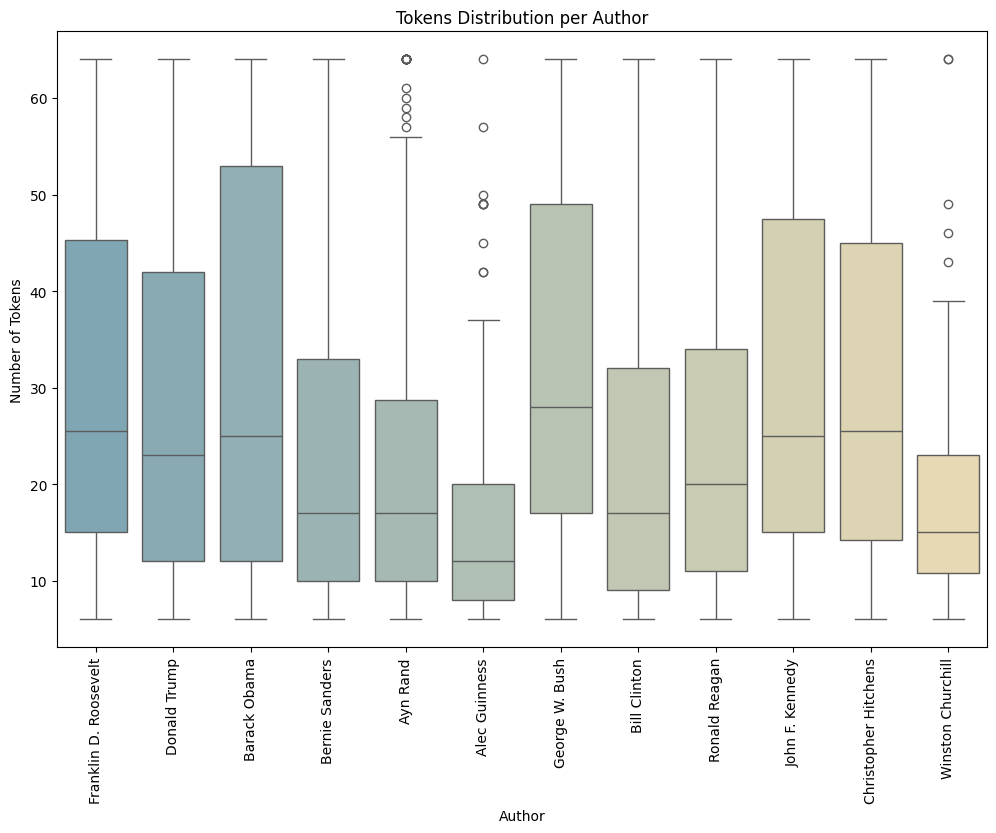

In [73]:
len(train_data)
plot_tokens_distribution(train_data)
train_data.to_csv('../../Data/WikiQuotes_train.csv', index=False)

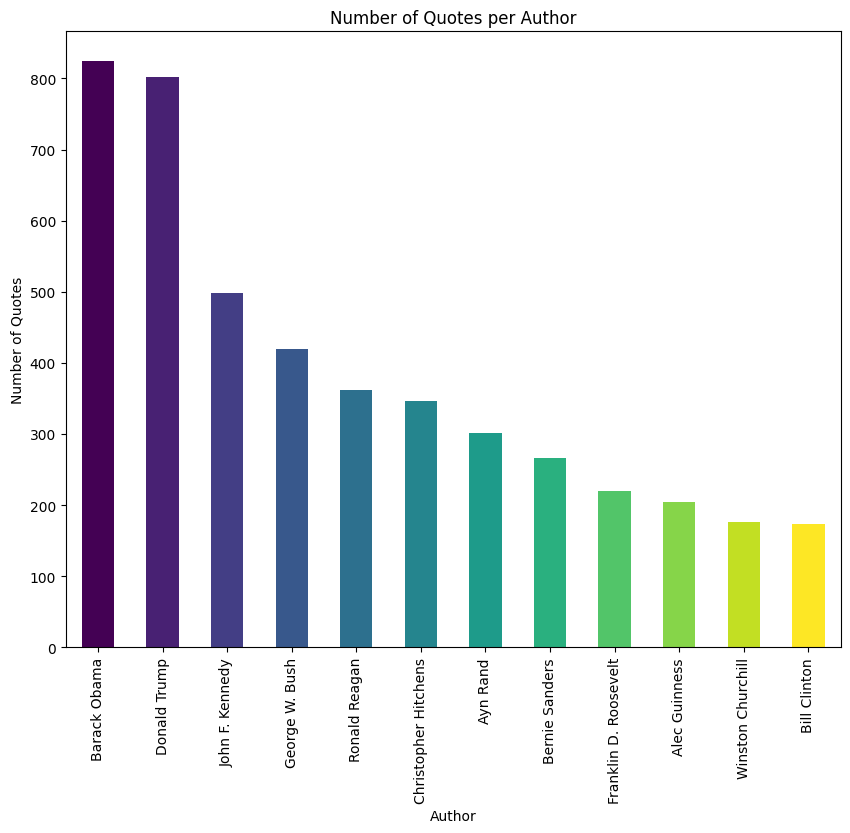

author_name
Barack Obama             825
Donald Trump             802
John F. Kennedy          499
George W. Bush           419
Ronald Reagan            362
Christopher Hitchens     346
Ayn Rand                 302
Bernie Sanders           266
Franklin D. Roosevelt    220
Alec Guinness            205
Winston Churchill        176
Bill Clinton             173
Name: count, dtype: int64

In [74]:
plot_author_quotes_count(train_data)

In [14]:
import pandas as pd
data = pd.read_csv('../../Data/WikiQuotes_train.csv')

In [17]:
rest_of_data = data[(data['label'] >= 3) & (data['label'] < 6)]
rest_of_data['label'].unique()


array([3, 4, 5])

In [10]:
data['label'] = data['label'].astype('int')
label_counts = data['label'].value_counts()
# label_counts
label_mapping = {old_label: new_label for new_label, old_label in enumerate(label_counts.index)}
data['label'] = data['label'].map(label_mapping)
author_id_map = data[['label', 'author_name']].drop_duplicates().set_index('label').to_dict()['author_name']
author_id_map

{8: 'Franklin D. Roosevelt',
 1: 'Donald Trump',
 0: 'Barack Obama',
 7: 'Bernie Sanders',
 6: 'Ayn Rand',
 9: 'Alec Guinness',
 3: 'George W. Bush',
 11: 'Bill Clinton',
 4: 'Ronald Reagan',
 2: 'John F. Kennedy',
 5: 'Christopher Hitchens',
 10: 'Winston Churchill'}

In [11]:
data_to_train = data[data['label'] <3]
data_to_train

,text,author_name,tokens,label,length,type
1,But I have made clear our trade imbalance is j...,Donald Trump,12,1,65,bona-fide
2,under very difficult circumstances is far grea...,Barack Obama,17,0,109,bona-fide
4,And advanced economies like my own unions have...,Barack Obama,16,0,109,bona-fide
5,My own family is made up of.,Barack Obama,7,0,28,bona-fide
8,things that were unacceptable to us.,Donald Trump,6,1,36,bona-fide
...,...,...,...,...,...,...
4577,The very word 'secrecy' is repugnant in a free...,John F. Kennedy,32,2,188,bona-fide
4579,If a free society cannot help the many who are...,John F. Kennedy,19,2,89,bona-fide
4581,Our most basic common link is that we all inha...,John F. Kennedy,29,2,152,bona-fide
4587,The path we have chosen for the present is ful...,John F. Kennedy,45,2,234,bona-fide


In [3]:
data['label'] = data['label'].astype('int')
label_counts = data['label'].value_counts()
# label_counts
label_mapping = {old_label: new_label for new_label, old_label in enumerate(label_counts.index)}
data['label'] = data['label'].map(label_mapping)

In [ ]:
data['label'] = data['label'].astype('int')
label_counts = data['label'].value_counts()


label
0     825
1     802
2     499
3     419
4     362
5     346
6     302
7     266
8     220
9     205
10    176
11    173
Name: count, dtype: int64

In [1]:
data.to_csv('../../Data/WikiQuotes_train.csv', index=False)

NameError: name 'data' is not defined

In [7]:
author_id_map = data[['label', 'author_name']].drop_duplicates().set_index('label').to_dict()['author_name']
author_id_map

{8: 'Franklin D. Roosevelt',
 1: 'Donald Trump',
 0: 'Barack Obama',
 7: 'Bernie Sanders',
 6: 'Ayn Rand',
 9: 'Alec Guinness',
 3: 'George W. Bush',
 11: 'Bill Clinton',
 4: 'Ronald Reagan',
 2: 'John F. Kennedy',
 5: 'Christopher Hitchens',
 10: 'Winston Churchill'}